# Investigating the wind force influence with SLIC model
Comparing lake data with simulation with a model that is unaware of the wind and with one that is aware of it.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [114]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
import inspect

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[05/30/23 13:59:16] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=158184;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=590575;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/30/23 13:59:16] INFO     Kedro project phd                                                      ]8;id=537750;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=375773;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=479260;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=644547;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=919573;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=557297;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=909539;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=48125;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=700120;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=649867;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=377641;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=630395;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=967388;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=973887;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=702002;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=28852;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=221384;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=649804;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [126]:
model_no_wind = model_loaders['SLIC_propeller']()
model_no_wind.control_keys = ['delta','rev',]
model_wind = model_loaders['SLIC_propeller_wind']()
model_wind.control_keys = ['delta','rev','twa','tws']

## First determine the neutral rudder angle $\delta_0$

In [7]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [63]:
model_no_wind.ship_parameters['I_z'] = 3386

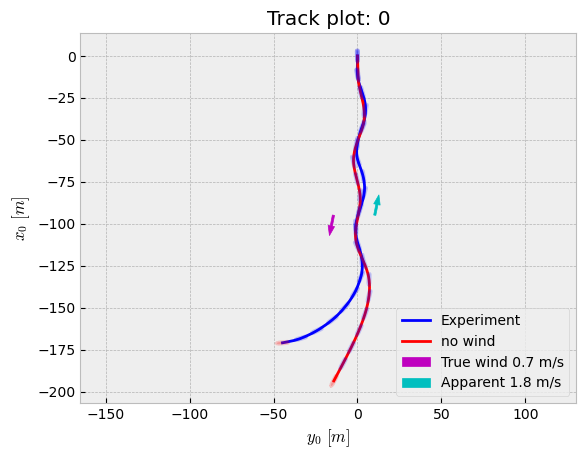

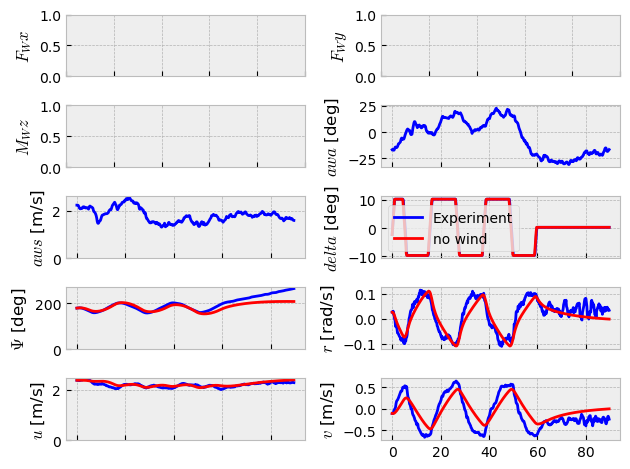

In [64]:
id = '0'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)

#data['awa'] = smallest_signed_angle(data['awa'])
#data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
#data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
#data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)

delta0 = -0.045
data['delta']-=delta0  # Neutral rudder angle added
rev_guess=14
data['rev'] = rev_guess  # Wild guess

try:
    result_no_wind = model_no_wind.simulate(data)
except:
    log.error(f"Failed to simulate model_no_wind for: {id}")
else:
    df_result_no_wind = result_no_wind.result.copy()

dataframes = {
    'Experiment':data,
    'no wind':result_no_wind.result
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window, units=units, symbols=symbols_dict);

In [10]:
mask = time_series_meta_data['type'] == 'zigzag'
time_series_meta_data_select = time_series_meta_data.loc[mask].sort_values(by='date')


results_no_wind = {}
results_wind = {}
rev_guess=14
    
for id, row in time_series_meta_data_select.iterrows():
    loader = time_series[id]
    
    data_raw = loader()
    #data_raw = fix_interpolated_angle(data=data_raw, key="awa", max_change=1.40)
        
    data = load(raw_data=data_raw)
    data.drop(columns=['mission','date'], inplace=True)
    #data['delta'] = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    data['delta']-=delta0  # Neutral rudder angle added
    data['rev'] = rev_guess  # Wild guess
    
    try:
        result_no_wind = model_no_wind.simulate(data)
    except:
        log.error(f"Failed to simulate model_no_wind for: {id}")
    else:
        df_result_no_wind = result_no_wind.result.copy()
        results_no_wind[id] = df_result_no_wind
    
    try:
        result_wind = model_wind.simulate(data)
    except:
        log.error(f"Failed to simulate model_wind for: {id}")
    else:
        df_result_wind = result_wind.result.copy()
        results_wind[id] = df_result_wind

In [28]:
catalog.save(f"{ ship }.simulation_no_wind", results_no_wind)
catalog.save(f"{ ship }.simulation_wind", results_wind)

[05/30/23 14:09:57] INFO     Saving data to '7m.simulation_no_wind' (PartitionedDataSet)...     ]8;id=403850;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=916370;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

[05/30/23 14:09:58] INFO     Saving data to '7m.simulation_wind' (PartitionedDataSet)...        ]8;id=178333;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=681790;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [29]:
renames = {symbol:key for key,symbol in df_parameters['symbol'].items()}

In [30]:
subs = [
(u,0),
(v,0),
(r,0),
(delta,0),
(u1d,0),
(v1d,0),
(r1d,0),
(thrust,0),
]
lambda_F_Wx = lambdify(model_wind.X_eq.rhs.subs(subs).subs(renames))
lambda_F_Wy = lambdify(model_wind.Y_eq.rhs.subs(subs).subs(renames))
lambda_M_Wz = lambdify(model_wind.N_eq.rhs.subs(subs).subs(renames))


In [31]:
lambda_F_Wx

<function _lambdifygenerated(A_XV, C_x0, C_x1, C_x2, C_x3, C_x4, C_x5, Xu, Xuu, awa, aws, rho_A, u)>

In [54]:
styles = {
"Experiment":{"style":'b-'},
"no_wind":{"style":'r-'},
"model with wind":{"style":'g-'},   
}

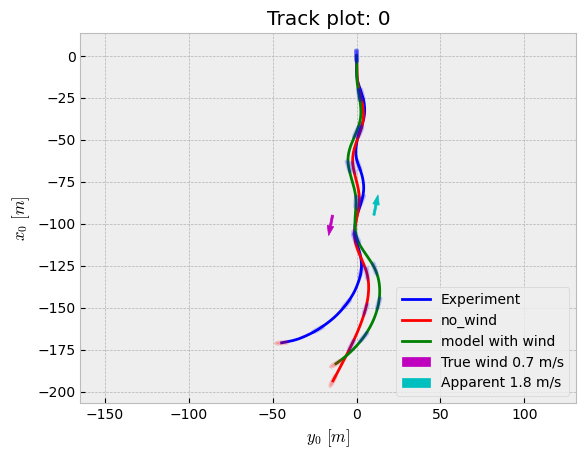

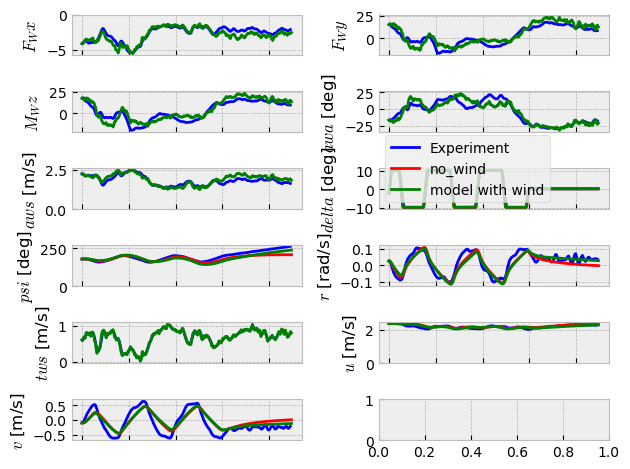

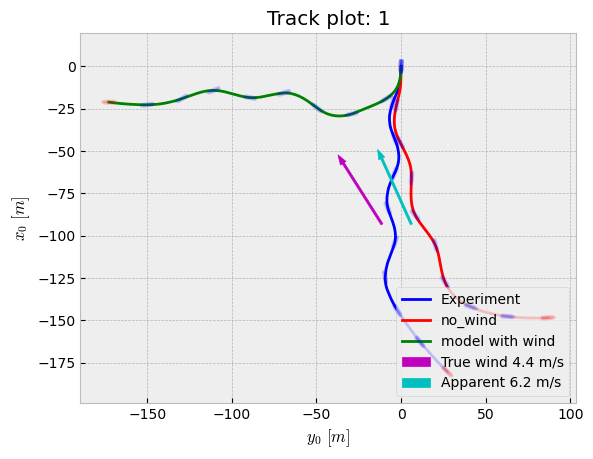

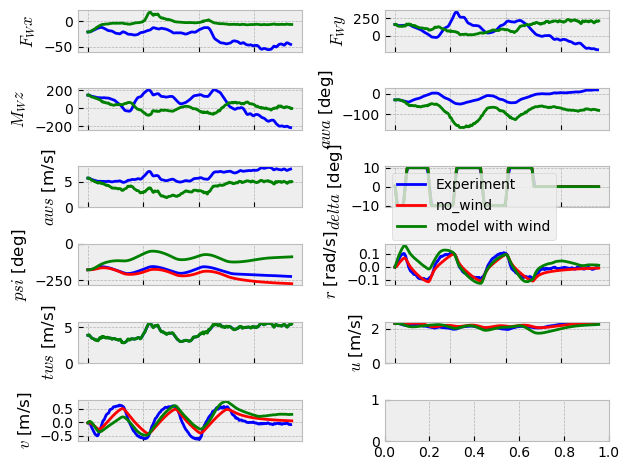

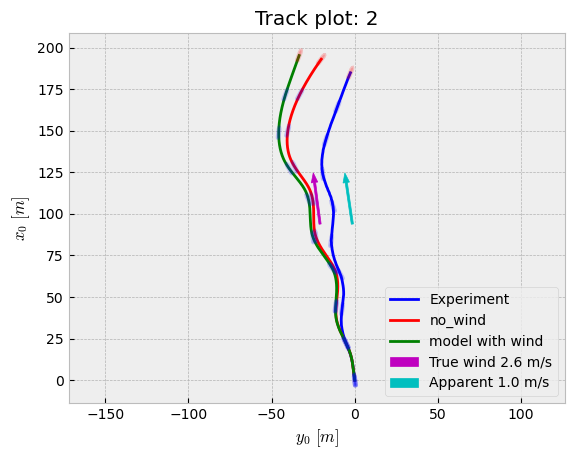

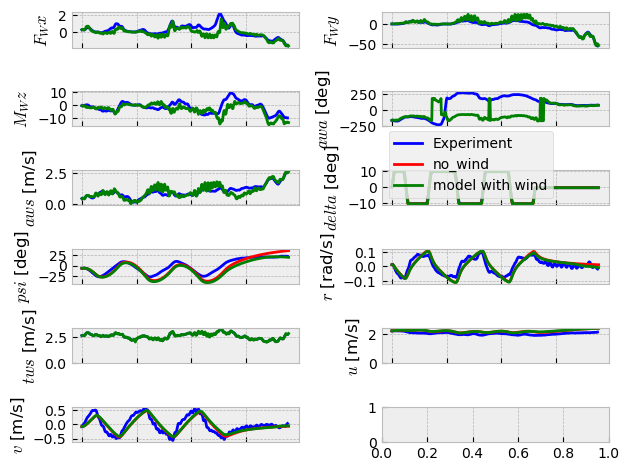

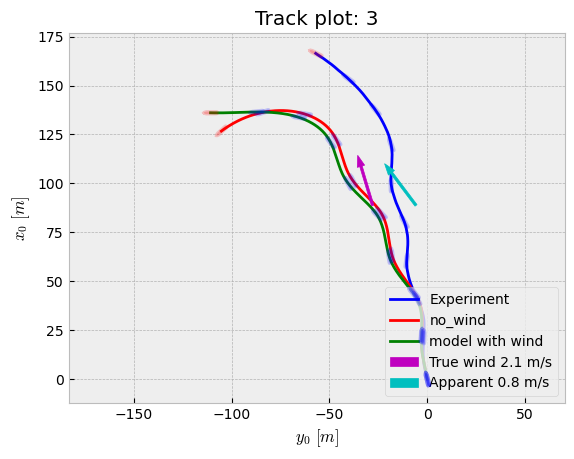

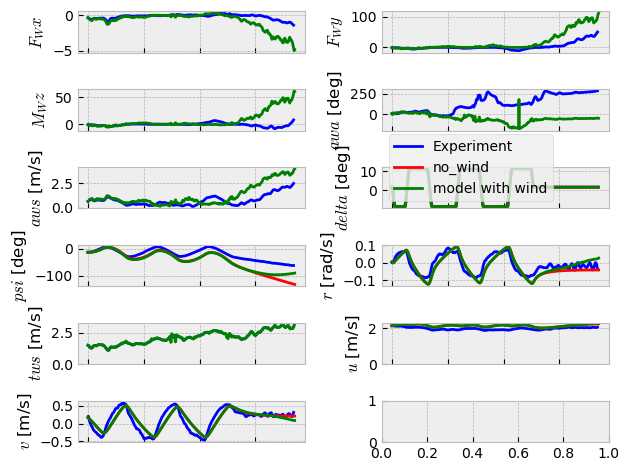

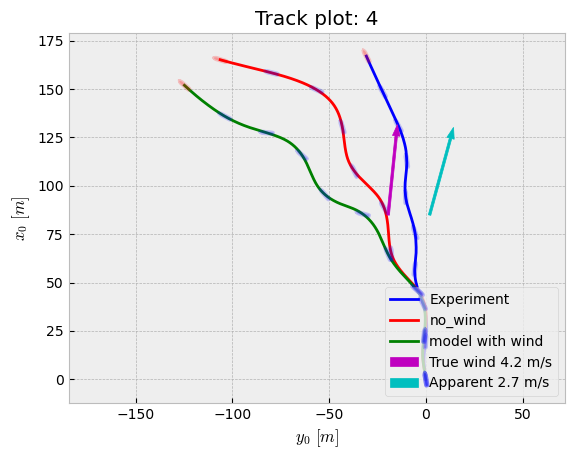

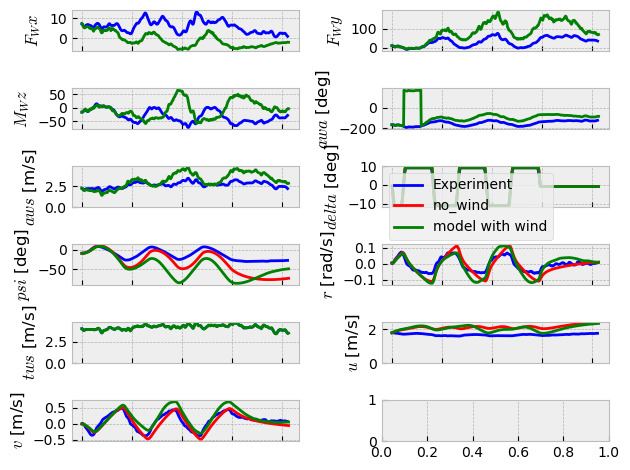

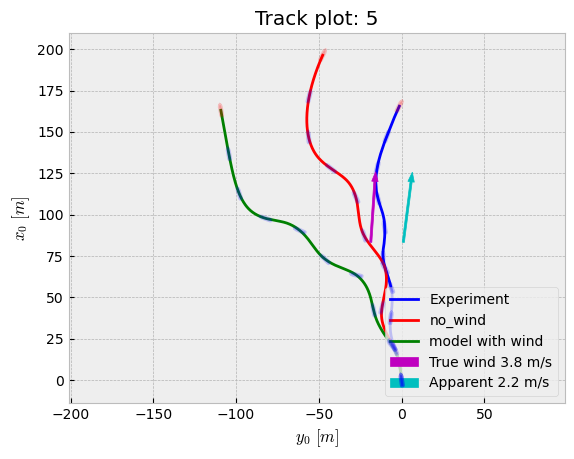

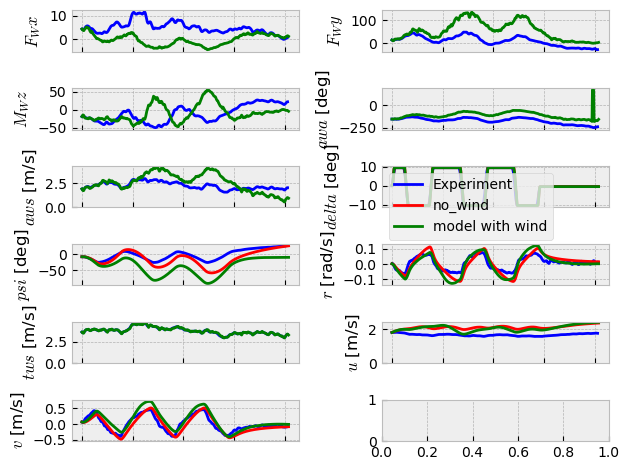

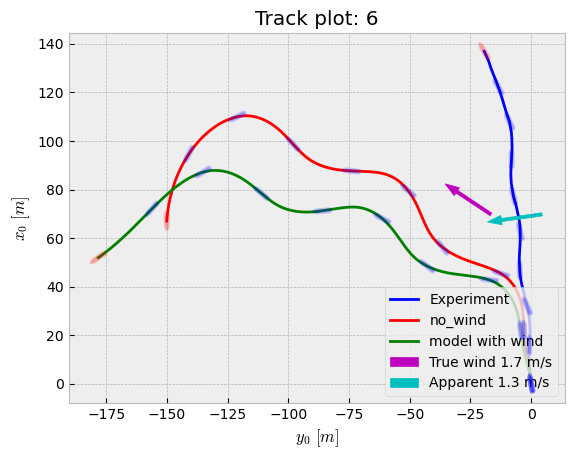

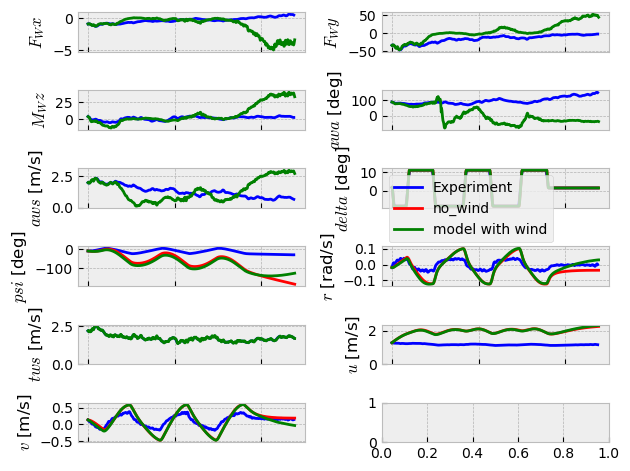

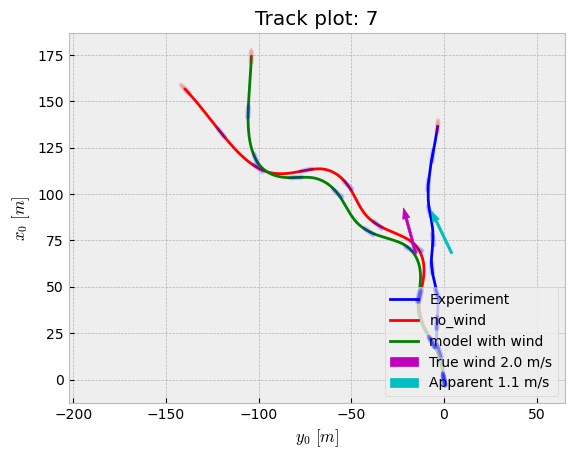

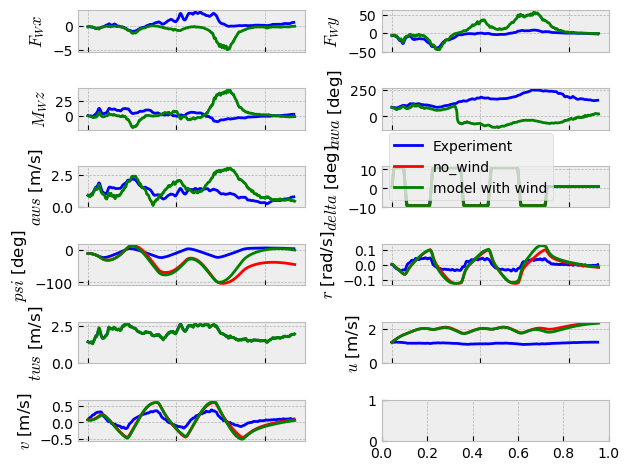

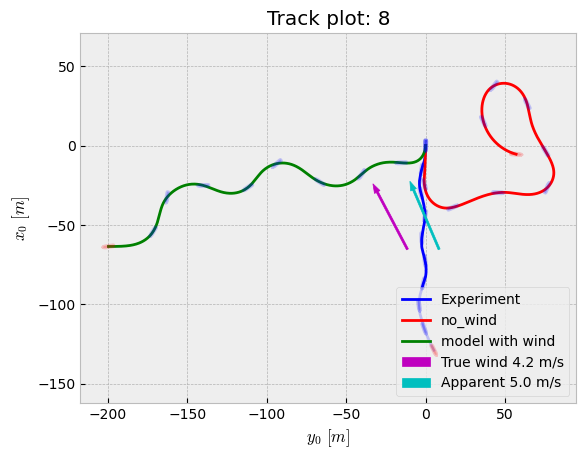

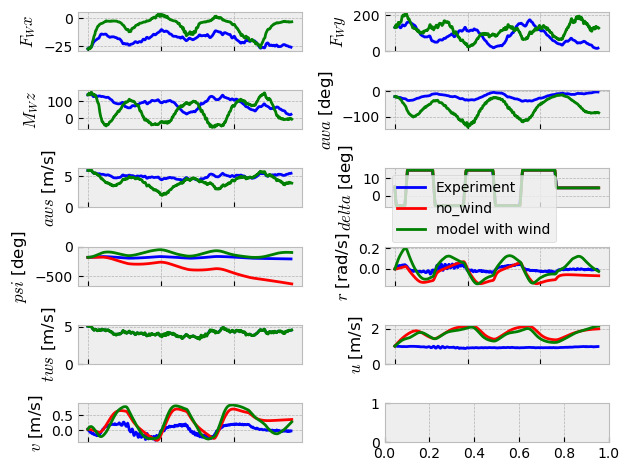

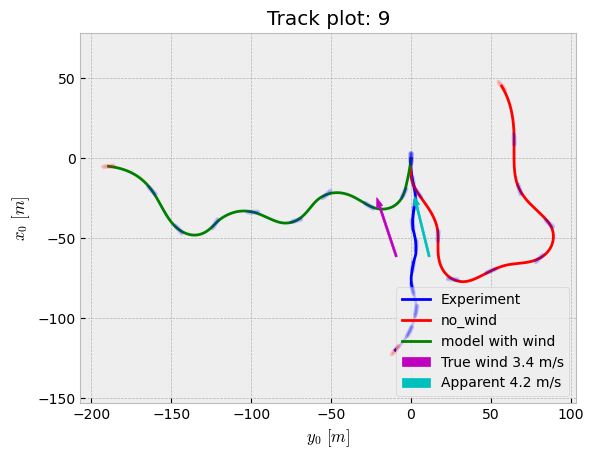

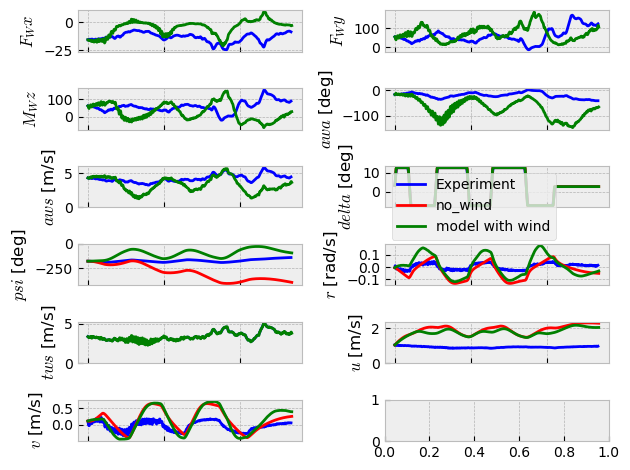

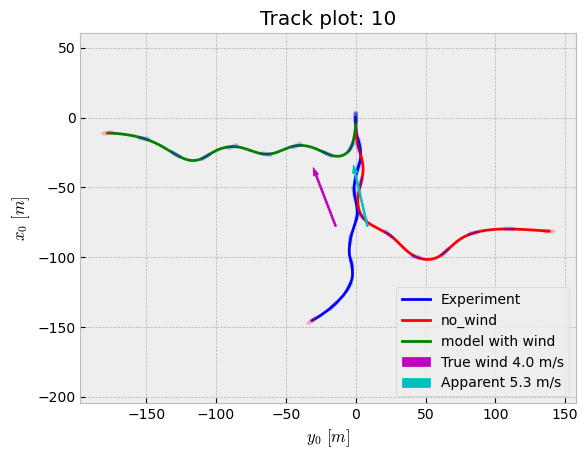

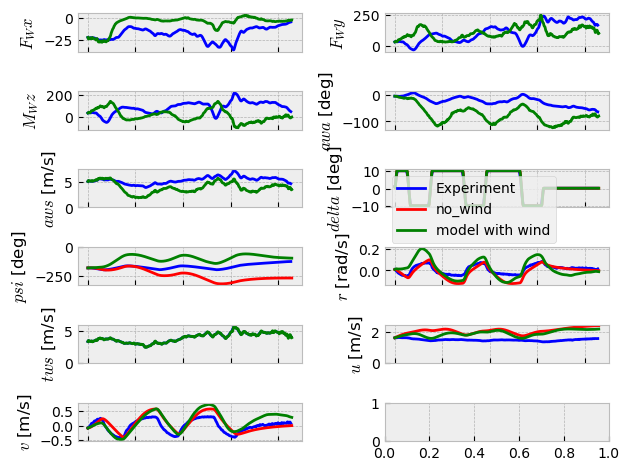

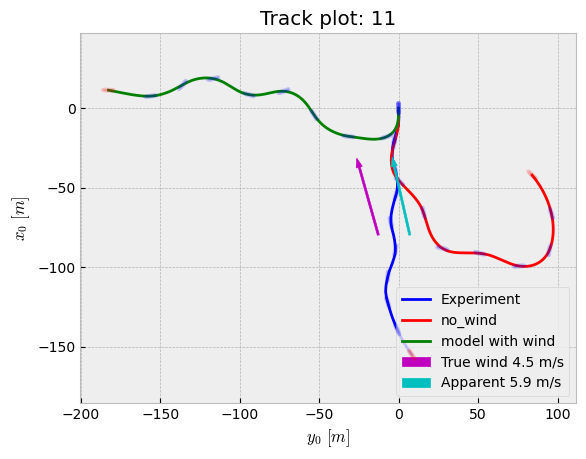

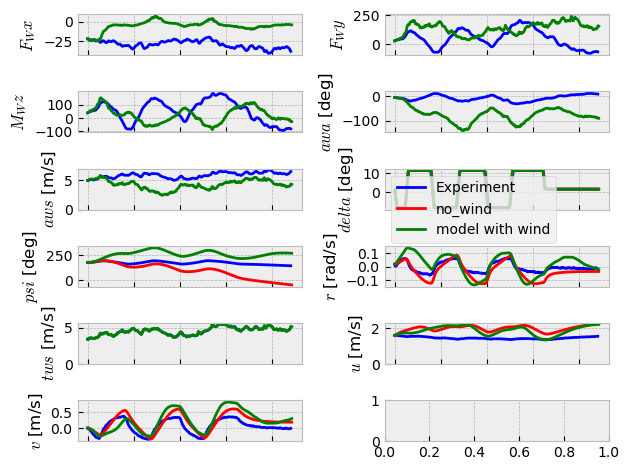

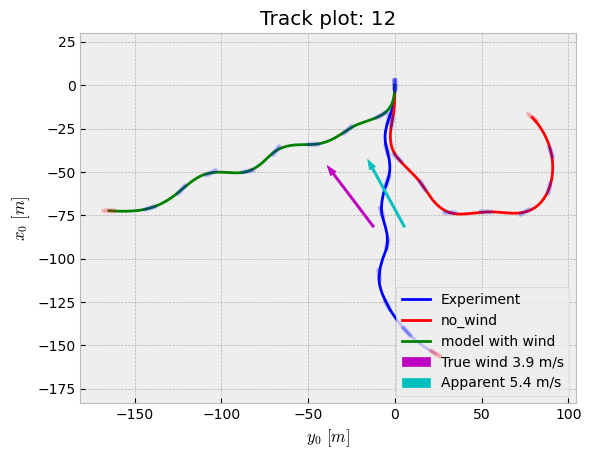

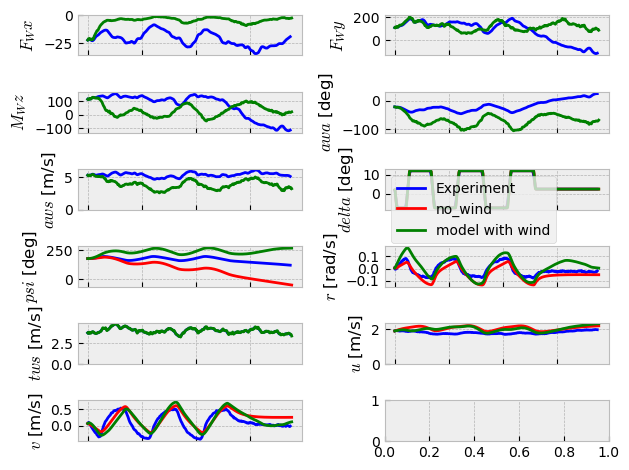

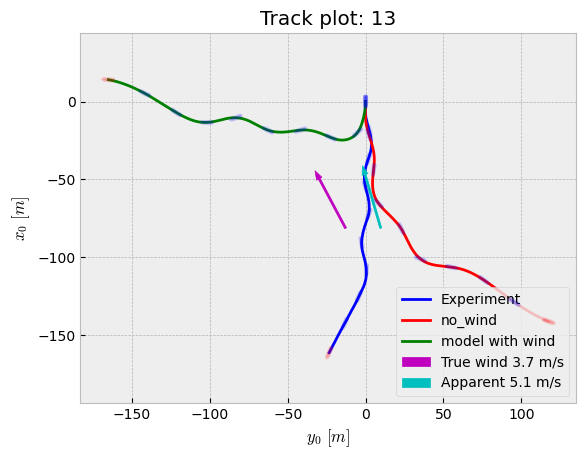

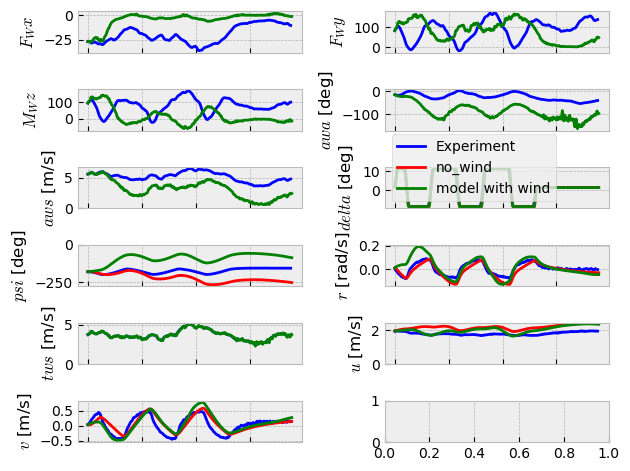

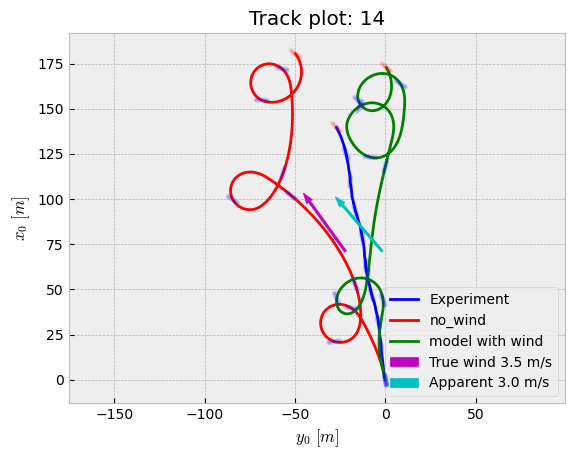

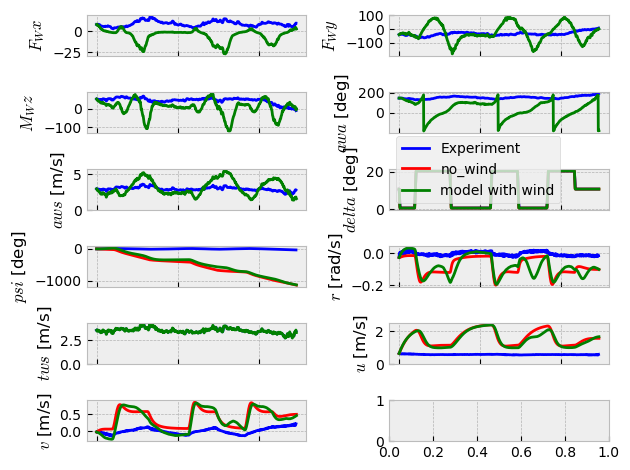

In [59]:
for id, row in time_series_meta_data_select.iterrows():
    
    loader = time_series[id]
    data_raw = loader()
    data = load(raw_data=data_raw)
    data.drop(columns=['mission','date'], inplace=True)
    data['delta']-=delta0  # Neutral rudder angle added
    
    dataframes = {
    'Experiment':data,       
    }
    if id in results_no_wind:
        result_no_wind = results_no_wind[id]
        dataframes['no_wind'] = result_no_wind
    if id in results_wind:
        result_wind = results_wind[id]
        result_wind_ = result_wind.copy()
        result_wind_['awa'] = smallest_signed_angle(result_wind_['awa'])
        result_wind['F_Wx'] = run(lambda_F_Wx, inputs=result_wind_, **ship_data, **model_wind.parameters)
        result_wind['F_Wy'] = run(lambda_F_Wy, inputs=result_wind_, **ship_data, **model_wind.parameters)
        result_wind['M_Wz'] = run(lambda_M_Wz, inputs=result_wind_, **ship_data, **model_wind.parameters)
        dataframes['model with wind'] = result_wind
            
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10, styles=styles);
    ax.legend(loc='lower right')
    ax.set_title(f'Track plot: {id}') 
    
    data_ = data.copy()
    data_['awa'] = smallest_signed_angle(data_['awa'])
    data['F_Wx'] = run(lambda_F_Wx, inputs=data_, **ship_data, **model_wind.parameters)
    data['F_Wy'] = run(lambda_F_Wy, inputs=data_, **ship_data, **model_wind.parameters)
    data['M_Wz'] = run(lambda_M_Wz, inputs=data_, **ship_data, **model_wind.parameters)
    
    data_ = data.rolling(6)
    data_ = mean(data_)
    data_['psi'] = np.unwrap(data_['psi'])
    dataframes['Experiment'] =  data_  
    
    plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','tws','F_Wx','F_Wy','M_Wz'], 
         time_window=time_window, units=units, styles=styles);
    

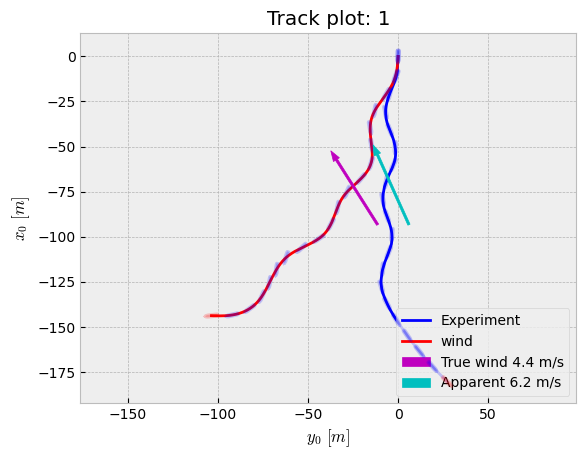

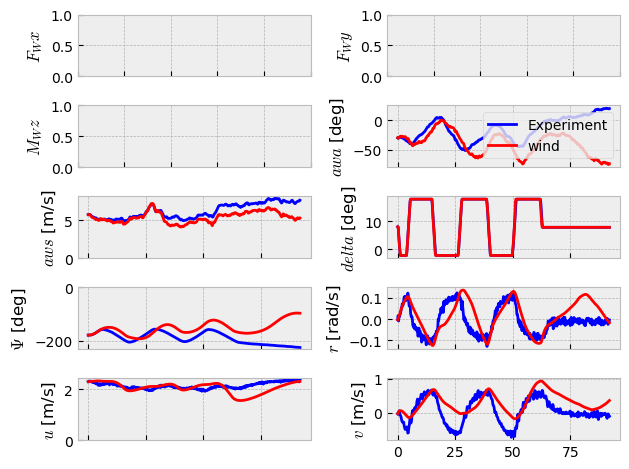

In [127]:
id = '1'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)

#data['awa'] = smallest_signed_angle(data['awa'])
#data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
#data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
#data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)

data['delta']-=-0.18  # Neutral rudder angle added
rev_guess=15
data['rev'] = rev_guess  # Wild guess

results = model_wind.simulate(data)

dataframes = {
    'Experiment':data,
    'wind':results.result
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window, units=units, symbols=symbols_dict);

In [133]:
X_forces, Y_forces, N_forces = results.simulate_parameter_contributions()

In [135]:
N_forces.head()

C_n1  C_n2  C_n3  Cn1  Cn2  Cn3    Ndelta        Nr  Nrdot  Nthrust  Nthrustdelta        Nu       Nur            Nv  Nvdot      Nvvdelta
0.000000   NaN   NaN   NaN  NaN  NaN  NaN -0.000278  0.000287    NaN      0.0 -9.416528e-07 -0.000003 -0.000273  4.441999e-07    NaN -1.883716e-07
0.201310   NaN   NaN   NaN  NaN  NaN  NaN -0.000273 -0.000144    NaN      0.0 -9.236065e-07 -0.000003  0.000137 -1.926500e-07    NaN -3.480292e-08
0.402621   NaN   NaN   NaN  NaN  NaN  NaN -0.000191 -0.000591    NaN      0.0 -6.449297e-07 -0.000003  0.000563 -7.197936e-07    NaN -3.398551e-07
0.603931   NaN   NaN   NaN  NaN  NaN  NaN -0.000103 -0.001113    NaN      0.0 -3.465136e-07 -0.000003  0.001059 -1.129450e-06    NaN -4.505185e-07
0.805242   NaN   NaN   NaN  NaN  NaN  NaN -0.000028 -0.001689    NaN      0.0 -9.281492e-08 -0.000003  0.001607 -1.411338e-06    NaN -1.888296e-07

In [148]:
mask = N_forces.columns.str.contains('delta')
columns_delta = N_forces.columns[mask]
forces_prime = pd.DataFrame(index=N_forces.index)
forces_prime['mz'] = N_forces[columns_delta].sum(axis=1)

forces = model_wind.prime_system.df_unprime(forces_prime, U=data["U"], units={'mz':'moment'})

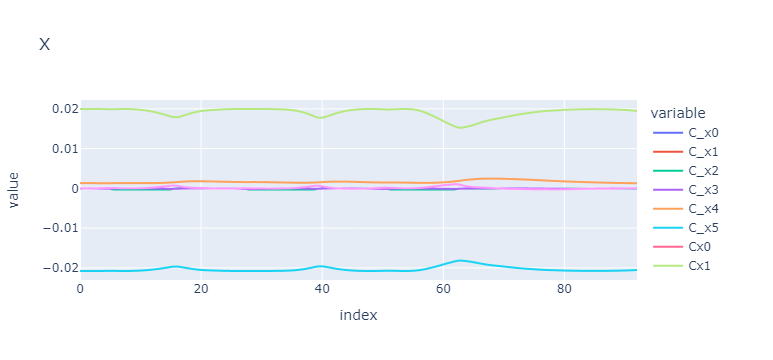

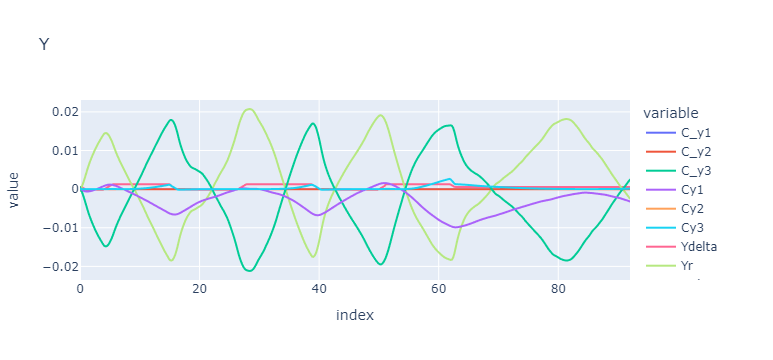

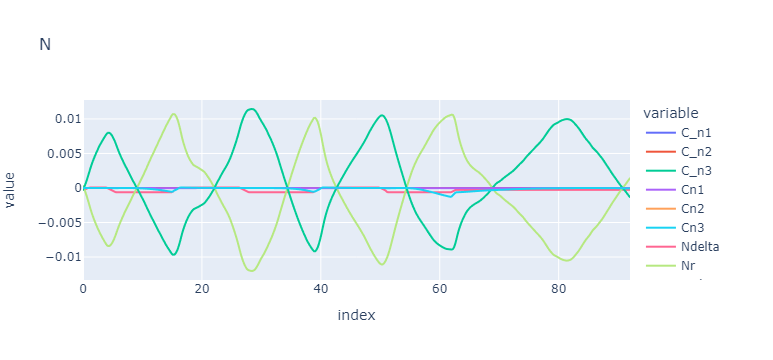

In [132]:
results.plot_parameter_contributions(to_mlflow=False)

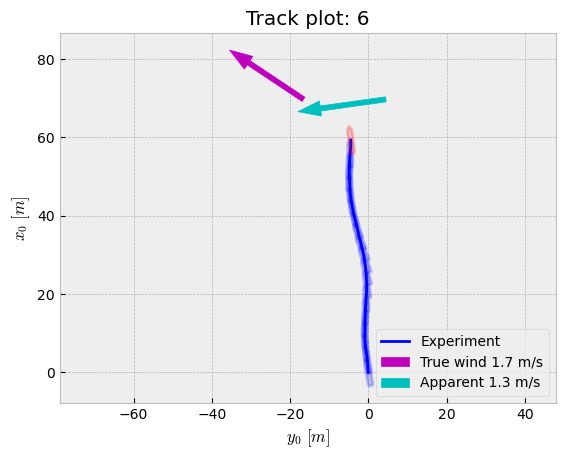

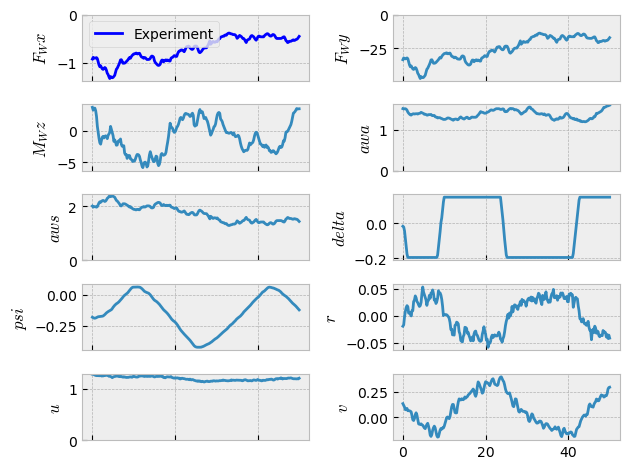

In [34]:
id = '6'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)

data['awa'] = smallest_signed_angle(data['awa'])
data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)


dataframes = {
    'Experiment':data,
}

time_window=[0,50]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window);

In [35]:
np.rad2deg(mean_angle(data['twa']))

123.65513778590257

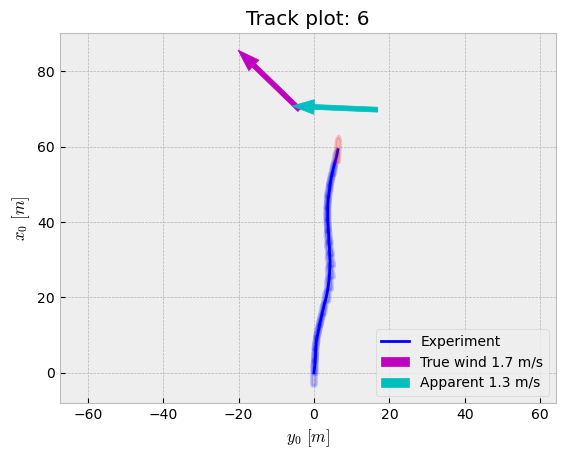

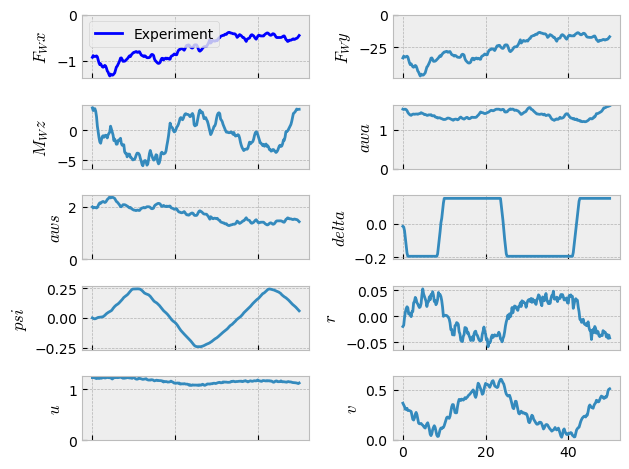

In [36]:
id = '6'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)

data['awa'] = smallest_signed_angle(data['awa'])
data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)


psi0 = -data['psi'].iloc[0].copy()
data['psi']+=psi0
data['cog']+=psi0
data['twa']+=psi0

x0 = data['x0']
y0 = data['y0']
data['x0'] = x0*np.cos(psi0) - y0*np.sin(psi0)
data['y0'] = x0*np.sin(psi0) + y0*np.cos(psi0)

u = data['u']
v = data['v']
data['u'] = u*np.cos(psi0) - v*np.sin(psi0)
data['v'] = u*np.sin(psi0) + v*np.cos(psi0)

dataframes = {
    'Experiment':data,
}

time_window=[0,50]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','F_Wx','F_Wy','M_Wz'], time_window=time_window);
    

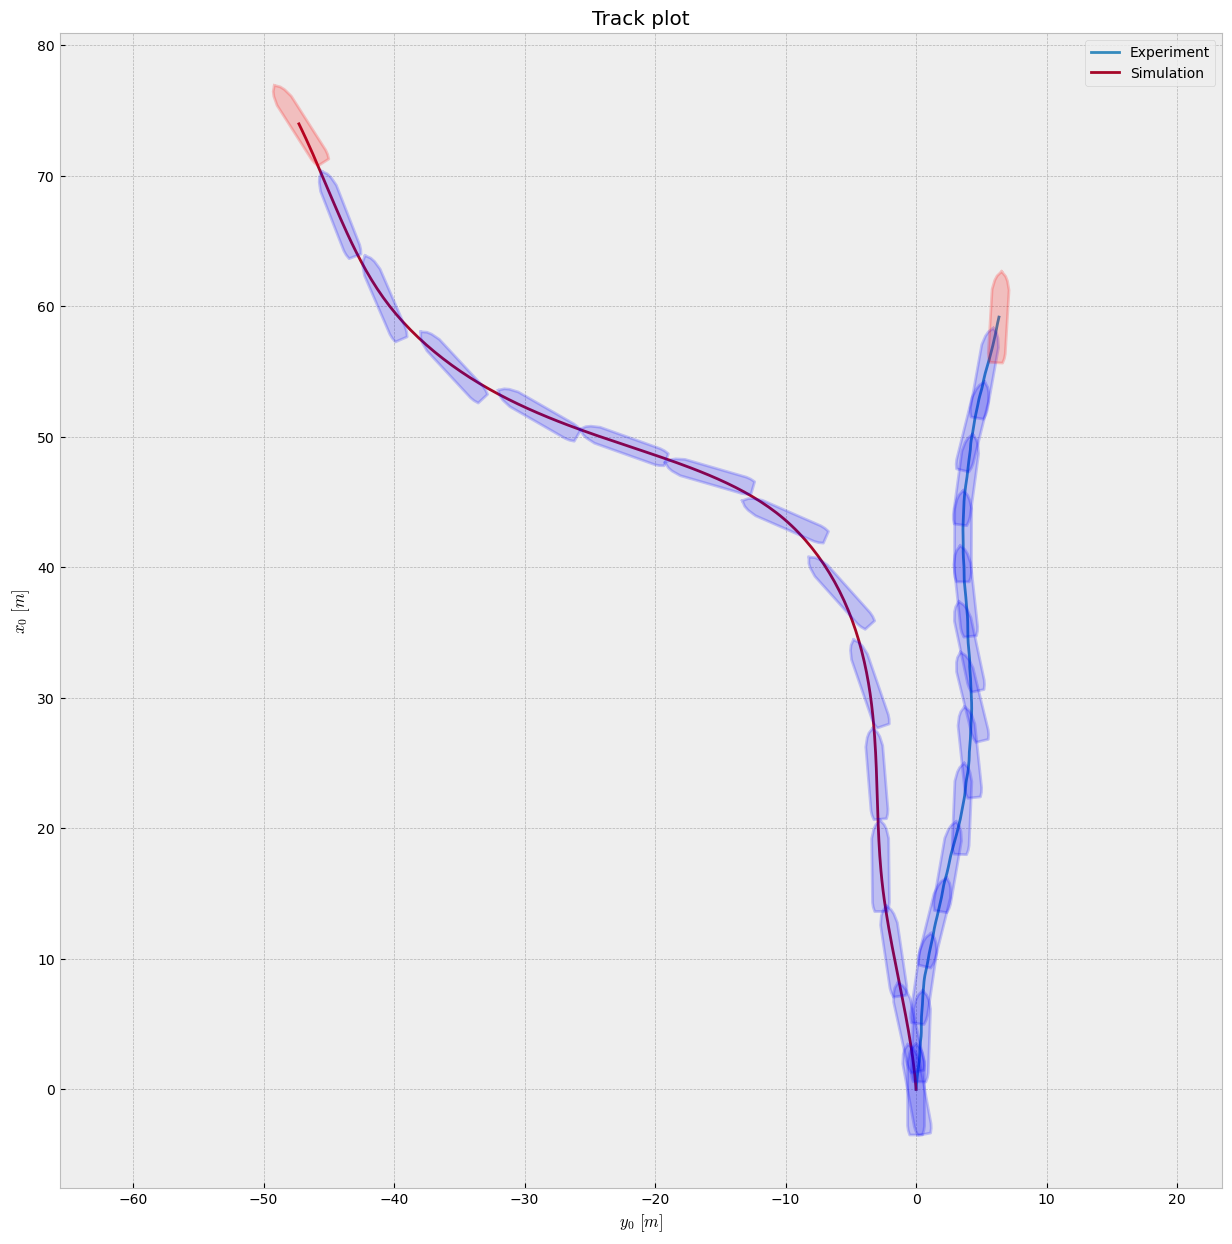

In [37]:
ax = track_plot(data, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, label='Experiment')

track_plot(results_no_wind[id], lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, label='Simulation', ax=ax)




ax.set_aspect("equal")
fig = ax.get_figure()
fig.set_size_inches(15,15)

In [38]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [39]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=model_no_wind.parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [40]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.3
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)                                         
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes['P_prd'][3][3]/=1000

In [41]:
x0 = initial_state(data)
#x0['v'] = 0.5

In [42]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=model_no_wind.parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=model_no_wind.parameters)

<Axes: xlabel='time(us)'>

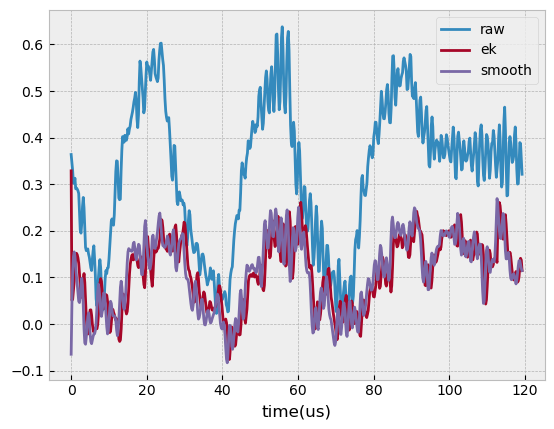

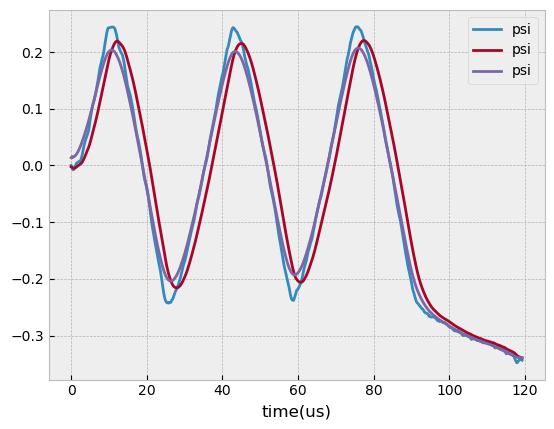

In [43]:
fig,ax=plt.subplots()
data.plot(y='v', label='raw', ax=ax)
data_ek.plot(y='v', label='ek', ax=ax)
data_ek_smooth.plot(y='v', label='smooth', ax=ax)
ax.legend()

fig,ax=plt.subplots()
data.plot(y='psi', ax=ax)
data_ek.plot(y='psi', ax=ax)
data_ek_smooth.plot(y='psi', ax=ax)

In [44]:
#data_ek_smooth['v'] = -0.5
result_no_wind = model_no_wind.simulate(data_ek_smooth)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 #data_ek_smooth['v'] = -0.5                                                                  │
│ ❱ 2 result_no_wind = model_no_wind.simulate(data_ek_smooth)                                      │
│   3                                                                                              │
│                                                                                                  │
│ /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/models/vmm.py:647 in simulate    │
│                                                                                                  │
│    644 │   │   **kwargs,                                                                         │
│    645 │   ) -> Result:                                                                          │
│    646 │   │                                                                                     │
│ ❱  647 │   │   return super().simulate(                                                          │
│    648 │   │   │   df_=df_,                                                                      │
│    649 │   │   │   parameters=self.parameters,                                                   │
│    650 │   │   │   ship_parameters=self.ship_parameters,                                         │
│                                                                                                  │
│ /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/models/vmm.py:450 in simulate    │
│                                                                                                  │
│    447 │   │   t_span = [t.min(), t.max()]                                                       │
│    448 │   │   t_eval = np.linspace(t.min(), t.max(), len(t))                                    │
│    449 │   │                                                                                     │
│ ❱  450 │   │   df_control = df_[control_keys]                                                    │
│    451 │   │                                                                                     │
│    452 │   │   self.primed_parameters = primed_parameters                                        │
│    453 │   │   if primed_parameters:                                                             │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/frame.py:3767 in           │
│ __getitem__                                                                                      │
│                                                                                                  │
│    3764 │   │   else:                                                                            │
│    3765 │   │   │   if is_iterator(key):                                                         │
│    3766 │   │   │   │   key = list(key)                                                          │
│ ❱  3767 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3768 │   │                                                                                    │
│    3769 │   │   # take() does not accept boolean indexers                                        │
│    3770 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/indexes/base.py:5876 in    │
│ _get_indexer_strict                                        

In [ ]:
ax = track_plot(data, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15)

track_plot(result_no_wind.result, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=15, ax=ax)




ax.set_aspect("equal")
fig = ax.get_figure()
fig.set_size_inches(15,15)

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['delta']))

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['twa']))

In [ ]:
np.rad2deg(mean_angle(data['twa']))

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['awa'] - (data.iloc[0]['awa'] - smallest_signed_angle(data.iloc[0]['awa']))))

In [ ]:
data['V'].mean()

In [ ]:
model_wind.forces(inputs=data[['u','v','V','r','delta','awa','aws']]).plot()

In [ ]:
result_no_wind.plot_parameter_contributions(to_mlflow=False)

In [ ]:
X_forces, Y_forces, N_forces = result_no_wind.simulate_parameter_contributions()

In [ ]:
mask = N_forces.columns.str.contains('delta')
columns = N_forces.columns[mask]
N_forces[columns].sum(axis=1).plot()

In [ ]:
units = {column:'moment' for column in N_forces.columns}

In [ ]:
N = model_wind.prime_system.df_unprime(N_forces, U=result_no_wind.result['U'], units=units)

In [ ]:
N[columns].sum(axis=1).plot()